# Prédiction du succès ou de l'échec d'une candidature à un poste

Dans ce projet, nous allons utiliser la data science pour voir si un candidat est susceptible d'être recruté à un poste de chercheur d'or en fonction des données qui le caractérisent.  

Le dataset a été fourni par un cabinet de conseil qui ne sera pas nommé.

## 1. Statistiques descriptives

On va commencer par importer les libraires permettant de visualiser les données puis on crée le dataframe pour avoir un premier aperçu des données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns            
from scipy import stats

def suppress_warnings():
    import warnings
    warnings.filterwarnings('ignore', category = DeprecationWarning) 
    warnings.filterwarnings('ignore', category = FutureWarning) 

import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected = True) # Required to use plotly offline in jupyter notebook

plt.style.use('bmh')                    # Use bmh's style for plotting
sns.set_style({'axes.grid':False})      # Remove gridlines

df = pd.read_csv("data_v1.0 (3).csv", index_col=0)
df.shape

(20000, 12)

In [2]:
df.head()

,index,date,cheveux,age,exp,salaire,sexe,diplome,specialite,note,dispo,embauche
0,0,2012-06-02,roux,25.0,9.0,26803.0,F,licence,geologie,97.08,non,0
1,1,2011-04-21,blond,35.0,13.0,38166.0,M,licence,forage,63.86,non,0
2,2,2012-09-07,blond,29.0,13.0,35207.0,M,licence,geologie,78.50,non,0
3,3,2011-07-01,brun,NaN,12.0,32442.0,M,licence,geologie,45.09,non,0
4,4,2012-08-07,roux,35.0,6.0,28533.0,F,licence,detective,81.91,non,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 12 columns):
index         20000 non-null int64
date          19909 non-null object
cheveux       19897 non-null object
age           19909 non-null float64
exp           19904 non-null float64
salaire       19905 non-null float64
sexe          19900 non-null object
diplome       19890 non-null object
specialite    19907 non-null object
note          19886 non-null float64
dispo         19894 non-null object
embauche      20000 non-null int64
dtypes: float64(4), int64(2), object(6)
memory usage: 2.0+ MB


Variables catégoriques : embauche, cheveux, sexe, diplome, specialite, dispo

Variables numériques : age, exp, salaire, note

La date est un cas à part que nous traiterons différemment.

## a. Analyse univariée des données

Commençons par une première observation globale des données

In [4]:
df.describe()

,index,age,exp,salaire,note,embauche
count,20000.000000,19909.000000,19904.000000,19905.000000,19886.000000,20000.000000
mean,9999.500000,35.004521,9.500352,34974.343934,75.168762,0.114600
std,5773.647028,9.609169,3.012109,5003.099616,17.095926,0.318547
min,0.000000,-3.000000,-2.000000,14128.000000,8.680000,0.000000
25%,4999.750000,29.000000,7.000000,31596.000000,63.720000,0.000000
50%,9999.500000,35.000000,9.000000,34979.000000,75.080000,0.000000
75%,14999.250000,41.000000,12.000000,38358.000000,86.617500,0.000000
max,19999.000000,74.000000,23.000000,53977.000000,143.220000,1.000000


On remarque des incohérences telles que le max de la note supérieur à 100, un age min inférieur à 0 et une expérience inférieure à 0. Regardons maintenant les données parmis les candidats embauchés.

On remarque aussi des grandes différents dans la ligne count : cela indique que l'on aura affaire à beaucoup de NaN.

In [5]:
df[df["embauche"] == 1].describe()

,index,age,exp,salaire,note,embauche
count,2292.000000,2282.000000,2284.000000,2285.000000,2276.000000,2292.0
mean,9704.530977,34.694128,9.555604,35006.883151,75.312329,1.0
std,5793.152514,9.742329,2.958165,4620.512606,15.993070,0.0
min,5.000000,1.000000,0.000000,17047.000000,21.260000,1.0
25%,4616.500000,28.000000,8.000000,31807.000000,64.265000,1.0
50%,9562.500000,35.000000,10.000000,34996.000000,75.110000,1.0
75%,14575.750000,41.000000,12.000000,38191.000000,85.820000,1.0
max,19996.000000,74.000000,20.000000,51093.000000,143.220000,1.0


On voit que l'age minimal pour un candidat embauché est de 1 an, ce qui est incohérent. L'age maximal est de 74, ce qui peut être cohérent pour un passionné de recherche. Dans tous les cas, il faudra nettoyer la donnée lors de l'apprentissage.

### a.1. Les variables discrètes

Nous allons commencer par définir deux fonctions afin de visualiser la fréquence en valeurs absolue et relative de chacune des variables, puis une troisième fonction pour tout afficher avec une seule ligne.

In [6]:
# Fonction qui affiche les bar labels en échelle absolue
def abs_bar_labels():
    font_size = 12
    plt.ylabel('Absolute Frequency', fontsize = font_size)
    plt.xticks(rotation = 0, fontsize = font_size)
    plt.yticks([])
    
    for x in ax.patches:
        ax.annotate(x.get_height(), 
        (x.get_x() + x.get_width()/2., x.get_height()), ha = 'center', va = 'center', xytext = (0, 7), 
        textcoords = 'offset points', fontsize = font_size, color = 'black')
    
# Fonction qui affiche les bar labels en échelle relative
def pct_bar_labels():
    font_size = 12
    plt.ylabel('Relative Frequency (%)', fontsize = font_size)
    plt.xticks(rotation = 0, fontsize = font_size)
    plt.yticks([]) 
    
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha = 'center', va = 'center', xytext = (0, 7), 
        textcoords = 'offset points', fontsize = font_size, color = 'black')
        
# Fonction qui affiche un dataframe des valeurs absolues et relatives + plot les deux fonctions précédentes
def absolute_and_relative_freq(variable):
    global  ax, ax1 
    # Dataframe
    absolute_frequency = variable.value_counts()
    relative_frequency = round(variable.value_counts(normalize = True)*100, 2)

    df = pd.DataFrame({'Fréquence absolue':absolute_frequency, 'Fréquence relative (%)':relative_frequency})
    print('Fréquences absolue et relative de ',variable.name,' :')
    display(df)
    
    # Valeur absolue
    fig_size = (15,4)
    font_size = 12
    title_size = 15
    ax =  absolute_frequency.plot.bar(title = 'Fréquence en valeur absolue de %s' %variable.name, figsize = fig_size)
    ax.title.set_size(title_size)
    abs_bar_labels()  # Displays bar labels in abs scale.
    plt.show()
    
    # Valeur relative
    ax1 = relative_frequency.plot.bar(title = 'Fréquence en valeur relative de %s' %variable.name, figsize = fig_size)
    ax1.title.set_size(title_size)
    pct_bar_labels() # Displays bar labels in relative scale.
    plt.show()

Fréquences absolue et relative de  embauche  :


,Fréquence absolue,Fréquence relative (%)
0,17708,88.54
1,2292,11.46


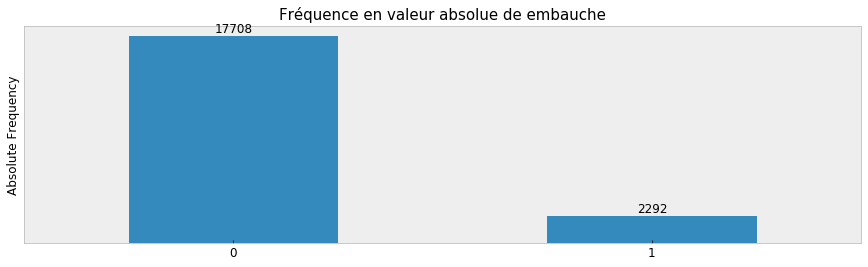

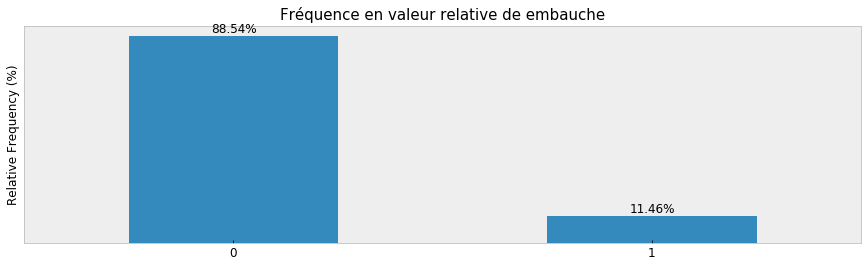

In [7]:
# Embauche
absolute_and_relative_freq(df.embauche)

On voit que seulement 11.46% des candidats ont été embauchés.

Sur le set complet
Fréquences absolue et relative de  cheveux  :


,Fréquence absolue,Fréquence relative (%)
chatain,6022,30.27
brun,5991,30.11
blond,5929,29.80
roux,1955,9.83


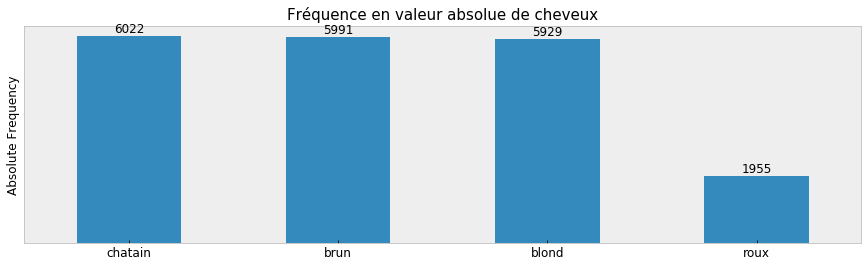

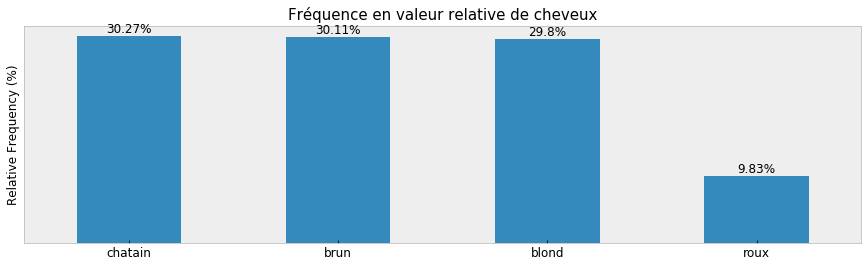

Uniquement pour les embauches
Fréquences absolue et relative de  cheveux  :


,Fréquence absolue,Fréquence relative (%)
brun,697,30.52
blond,694,30.39
chatain,669,29.29
roux,224,9.81


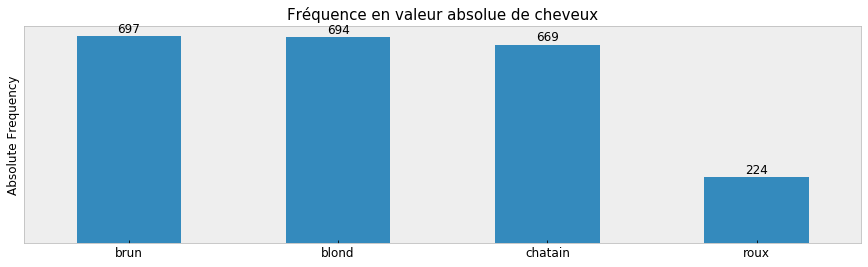

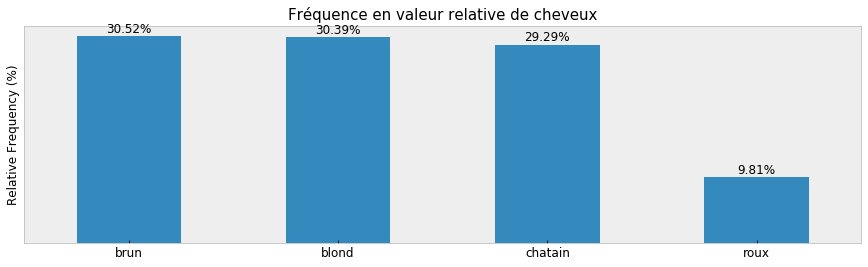

In [8]:
# Cheveux
print("Sur le set complet")
absolute_and_relative_freq(df.cheveux)
print("Uniquement pour les embauches")
absolute_and_relative_freq(df[df["embauche"] == 1].cheveux)

Les couleurs ne sont pas distribuées de manière égale entre les candidats. Il y a en effet trois fois moins de roux par rapport aux autres couleurs de cheveux qui sont, elles, équitablement distribuées entre elles.

Sur le set complet
Fréquences absolue et relative de  sexe  :


,Fréquence absolue,Fréquence relative (%)
M,11889,59.74
F,8011,40.26


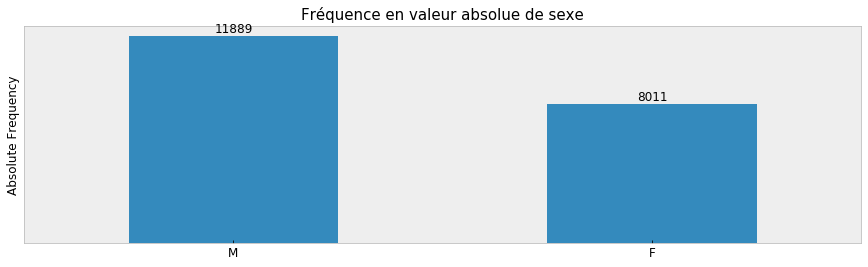

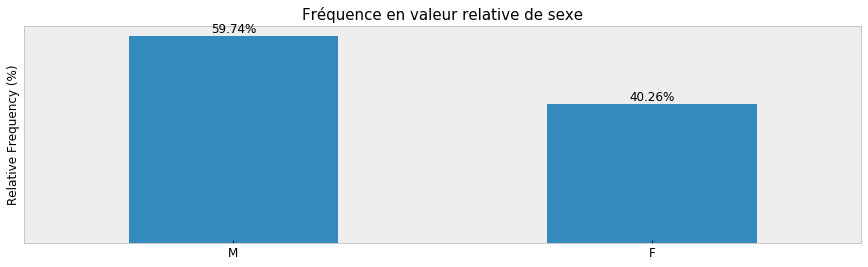

Uniquement pour les embauches
Fréquences absolue et relative de  sexe  :


,Fréquence absolue,Fréquence relative (%)
M,1456,63.86
F,824,36.14


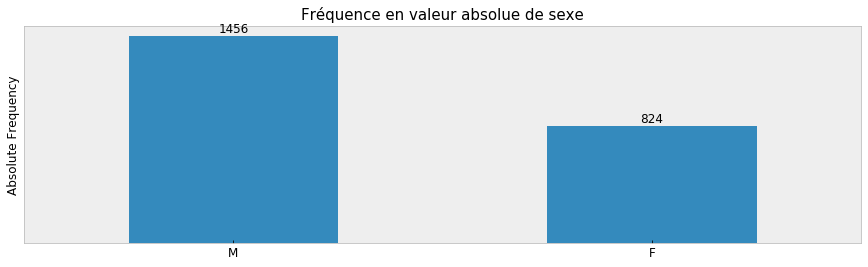

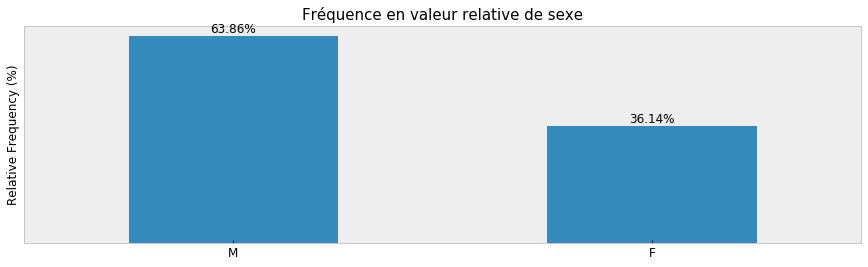

In [9]:
# Sexe
print("Sur le set complet")
absolute_and_relative_freq(df.sexe)
print("Uniquement pour les embauches")
absolute_and_relative_freq(df[df["embauche"] == 1].sexe)

Ici aussi, la variable n'est pas équilibrée : 59.74% des labels sont des hommes contre seulement 40.26% de femmes.

Sur le set complet
Fréquences absolue et relative de  diplome  :


,Fréquence absolue,Fréquence relative (%)
master,7513,37.77
licence,7377,37.09
doctorat,2547,12.81
bac,2453,12.33


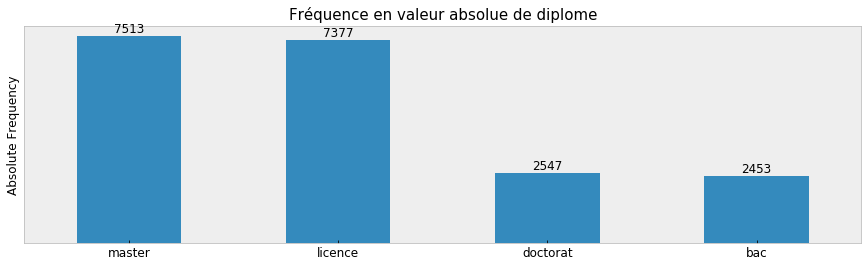

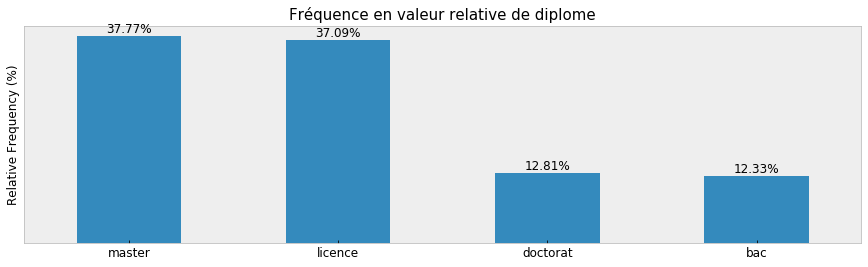

Uniquement pour les embauches
Fréquences absolue et relative de  diplome  :


,Fréquence absolue,Fréquence relative (%)
master,951,41.80
licence,897,39.43
doctorat,223,9.80
bac,204,8.97


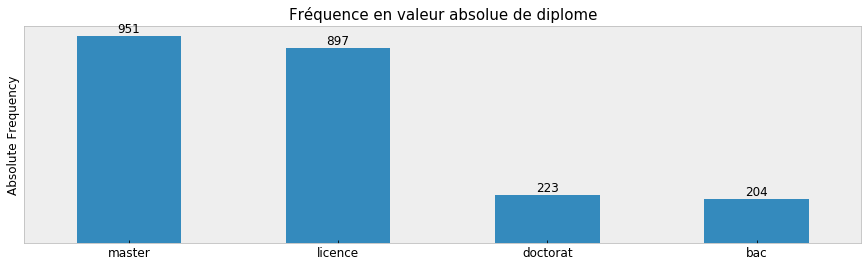

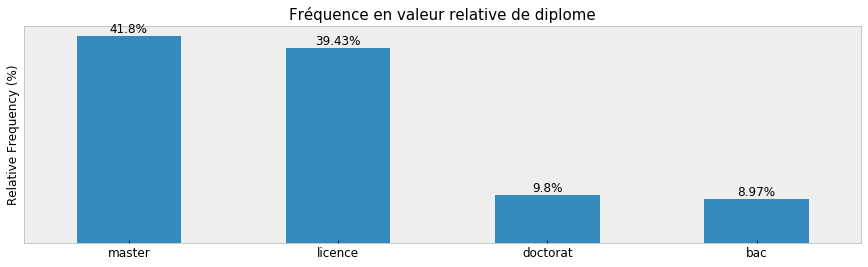

In [10]:
# Diplome
print("Sur le set complet")
absolute_and_relative_freq(df.diplome)
print("Uniquement pour les embauches")
absolute_and_relative_freq(df[df["embauche"] == 1].diplome)

On remarque ici un déséquilibre entre les différents diplômes : beaucoup plus de masters et licences (respectivement 37.77% et 37.09%) que de doctorats et bacs (respectivement 12.81% et 12.33%)

Sur le set complet
Fréquences absolue et relative de  specialite  :


,Fréquence absolue,Fréquence relative (%)
geologie,10028,50.37
forage,4340,21.80
detective,4155,20.87
archeologie,1384,6.95


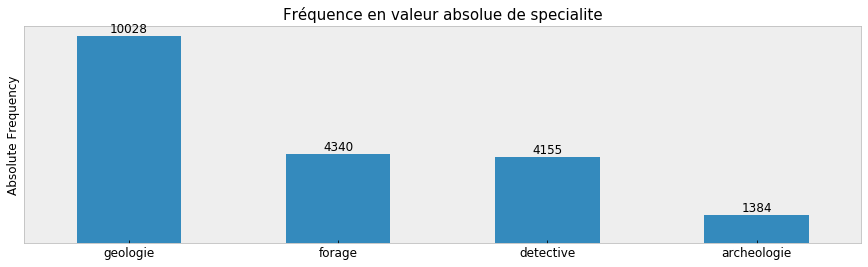

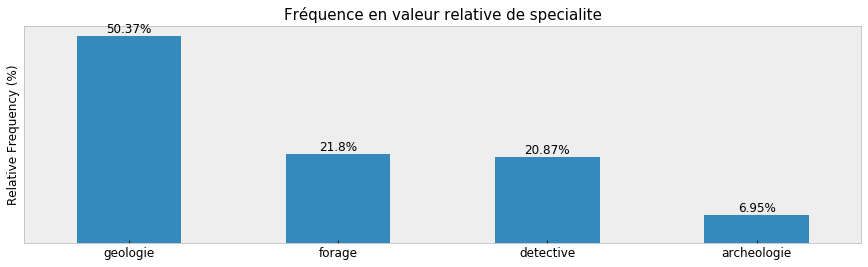

Uniquement pour les embauches
Fréquences absolue et relative de  specialite  :


,Fréquence absolue,Fréquence relative (%)
geologie,1181,51.68
detective,421,18.42
forage,396,17.33
archeologie,287,12.56


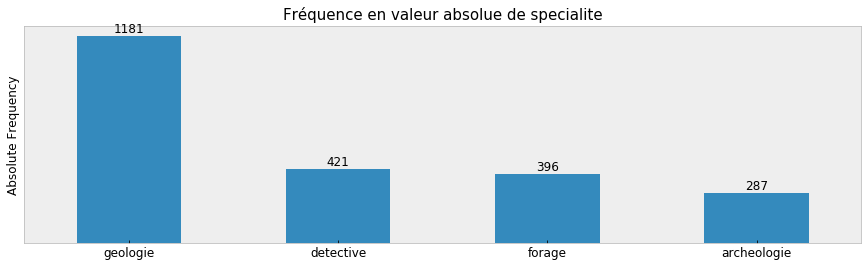

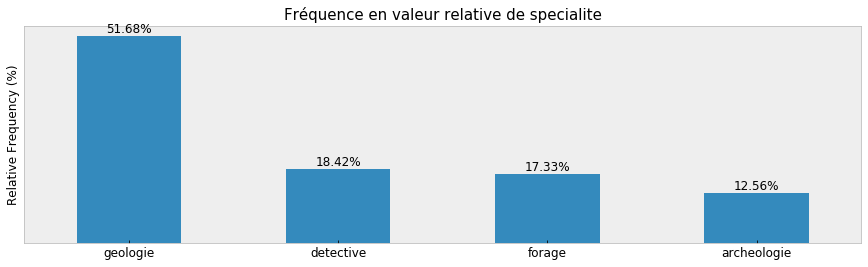

In [11]:
# Specialité
print("Sur le set complet")
absolute_and_relative_freq(df.specialite)
print("Uniquement pour les embauches")
absolute_and_relative_freq(df[df["embauche"] == 1].specialite)

Plus de la moitié des spécialités sont en géologie, contre forage et detective qui sont tous les deux proches de 20% et archéologie qui est sous-représentée avec moins de 7%.

Sur le set complet
Fréquences absolue et relative de  dispo  :


,Fréquence absolue,Fréquence relative (%)
non,11848,59.56
oui,8046,40.44


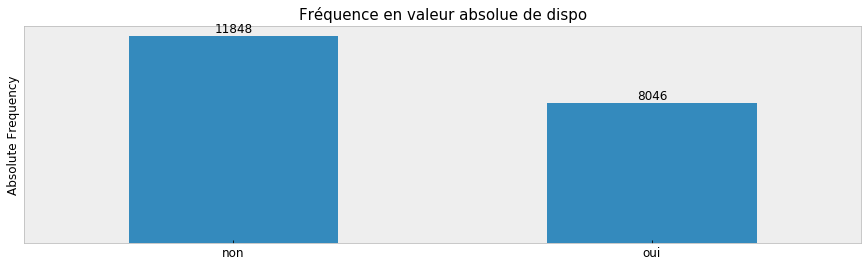

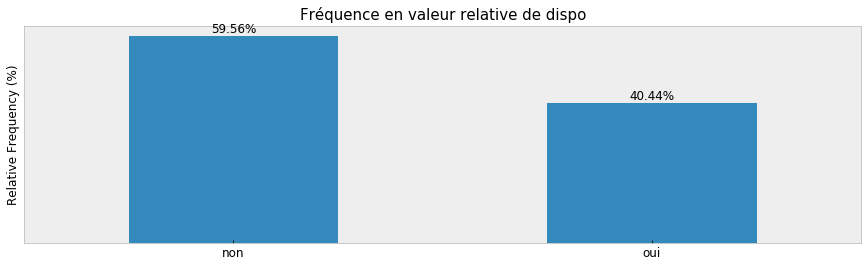

Uniquement pour les embauches
Fréquences absolue et relative de  dispo  :


,Fréquence absolue,Fréquence relative (%)
non,1324,58.1
oui,955,41.9


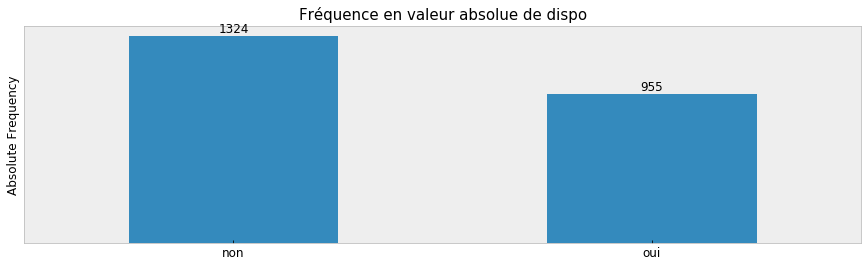

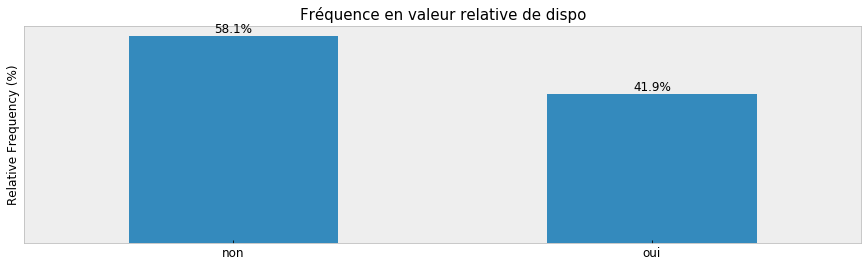

In [12]:
# Dispo
print("Sur le set complet")
absolute_and_relative_freq(df.dispo)
print("Uniquement pour les embauches")
absolute_and_relative_freq(df[df["embauche"] == 1].dispo)

Une distribution inégale avec plus de la moitié des candidats qui ne sont pas disponibles tout de suite (exactement 59.56%).

Pour la date de la candidature, effectuons une discrétisation par semestre afin d'avoir une idée des tendances.

In [13]:
df.loc[ (pd.DatetimeIndex(df['date']).month >= 1) & (pd.DatetimeIndex(df['date']).month <= 6) & (pd.DatetimeIndex(df['date']).year == 2010) , 'semestre'] = "S1 2010"
df.loc[ (pd.DatetimeIndex(df['date']).month >= 7) & (pd.DatetimeIndex(df['date']).month <= 12) & (pd.DatetimeIndex(df['date']).year == 2010) , 'semestre'] = "S2 2010"
df.loc[ (pd.DatetimeIndex(df['date']).month >= 1) & (pd.DatetimeIndex(df['date']).month <= 6) & (pd.DatetimeIndex(df['date']).year == 2011) , 'semestre'] = "S1 2011"
df.loc[ (pd.DatetimeIndex(df['date']).month >= 7) & (pd.DatetimeIndex(df['date']).month <= 12) & (pd.DatetimeIndex(df['date']).year == 2011) , 'semestre'] = "S2 2011"
df.loc[ (pd.DatetimeIndex(df['date']).month >= 1) & (pd.DatetimeIndex(df['date']).month <= 6) & (pd.DatetimeIndex(df['date']).year == 2012) , 'semestre'] = "S1 2012"
df.loc[ (pd.DatetimeIndex(df['date']).month >= 7) & (pd.DatetimeIndex(df['date']).month <= 12) & (pd.DatetimeIndex(df['date']).year == 2012) , 'semestre'] = "S2 2012"
df.loc[ (pd.DatetimeIndex(df['date']).month >= 1) & (pd.DatetimeIndex(df['date']).month <= 6) & (pd.DatetimeIndex(df['date']).year == 2013) , 'semestre'] = "S1 2013"
df.loc[ (pd.DatetimeIndex(df['date']).month >= 7) & (pd.DatetimeIndex(df['date']).month <= 12) & (pd.DatetimeIndex(df['date']).year == 2013) , 'semestre'] = "S2 2013"
df.loc[ (pd.DatetimeIndex(df['date']).month >= 1) & (pd.DatetimeIndex(df['date']).month <= 6) & (pd.DatetimeIndex(df['date']).year == 2014) , 'semestre'] = "S1 2014"
df.loc[ (pd.DatetimeIndex(df['date']).month >= 7) & (pd.DatetimeIndex(df['date']).month <= 12) & (pd.DatetimeIndex(df['date']).year == 2014) , 'semestre'] = "S2 2014"

Sur le set complet
Fréquences absolue et relative de  semestre  :


,Fréquence absolue,Fréquence relative (%)
S2 2013,2076,10.43
S2 2014,2035,10.22
S1 2010,2015,10.12
S2 2010,2011,10.10
S1 2012,2006,10.08
S1 2013,2005,10.07
S2 2011,1989,9.99
S2 2012,1944,9.76
S1 2014,1926,9.67
S1 2011,1902,9.55


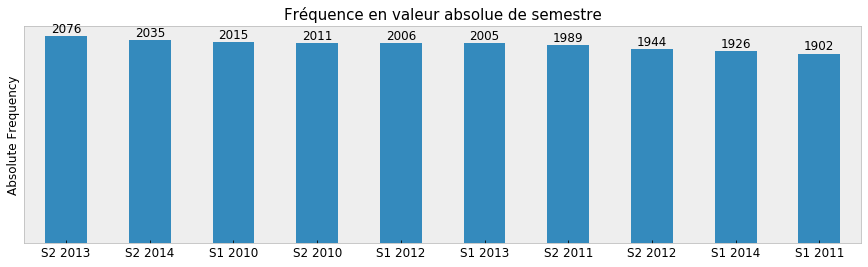

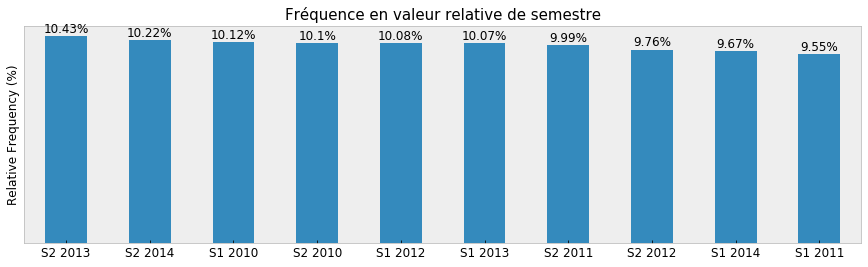

Uniquement pour les embauches
Fréquences absolue et relative de  semestre  :


,Fréquence absolue,Fréquence relative (%)
S2 2013,263,11.56
S1 2013,253,11.12
S2 2011,245,10.77
S1 2012,244,10.73
S2 2012,230,10.11
S1 2014,229,10.07
S2 2010,218,9.58
S2 2014,215,9.45
S1 2010,191,8.40
S1 2011,187,8.22


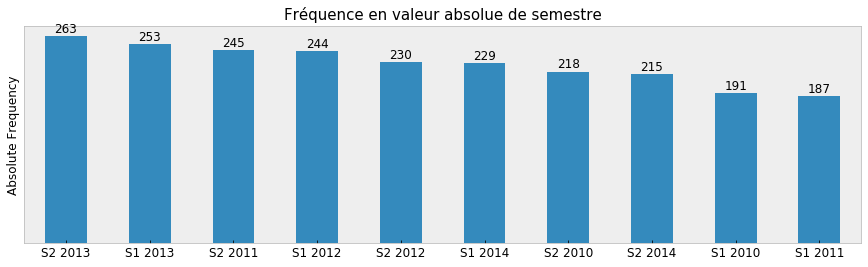

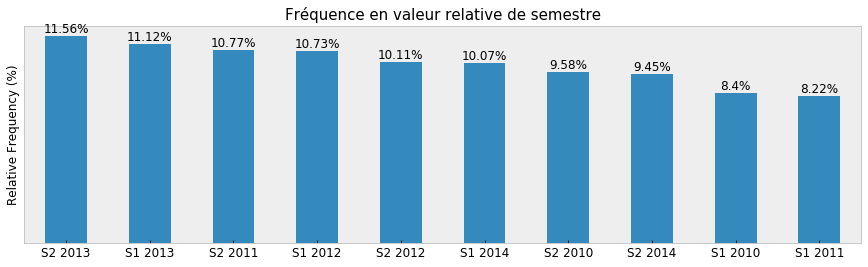

In [14]:
# Date
print("Sur le set complet")
absolute_and_relative_freq(df.semestre)
print("Uniquement pour les embauches")
absolute_and_relative_freq(df[df["embauche"] == 1].semestre)

On voit ici qu'il n'y a pas de forte "saison d'embauche". Les différences entre les saisons n'est pas remarquable, cependant on voit une baisse constante.

### a.2. Les variables continues

Pour les variables continues, on va représenter un histogramme, une densité et des statistiques descriptives.

In [15]:
# Hitogramme
def histogram(variable):
    global ax
    fig_size = (15,4)
    font_size = 12
    title_size = 15
    ax = variable.plot.hist(figsize = fig_size, color = 'teal')
    plt.xlabel('%s' %variable.name, fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.title('Histogramme de distribution pour %s' %variable.name, fontsize = title_size)
    abs_bar_labels()
    plt.show()
    
# Densité
def density_plot(variable):
    fig_size = (15,4)
    font_size = 12
    title_size = 15
    plt.figure(figsize = fig_size)
    variable.plot.hist(density = True, color = 'orchid')
    variable.plot.kde(style = 'k--')
    plt.xlabel('%s'%variable.name, fontsize = font_size)
    plt.ylabel('Density', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.title('Distribution avec graphe et histogramme pour %s' %variable.name, fontsize = title_size)
    plt.show()
    
# Statistiques
def summary_stats(variable):
    stats = variable.describe()
    skew = pd.Series(variable.skew(), index = ['skewness'])
    df_stats = pd.DataFrame(pd.concat([skew, stats], sort = False), columns = [variable.name])
    df_stats.index.name = 'Stats'
    display(df_stats)

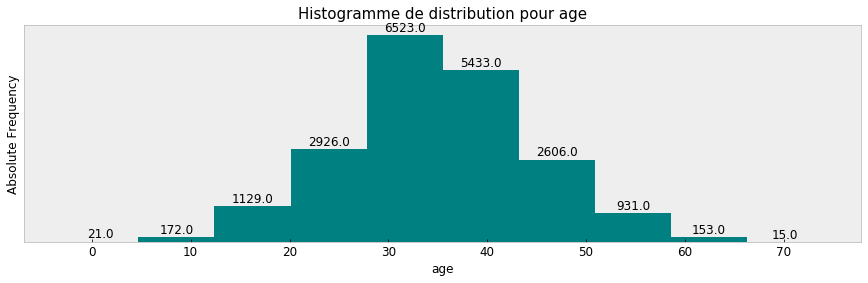

In [16]:
# Age
histogram(df.age)

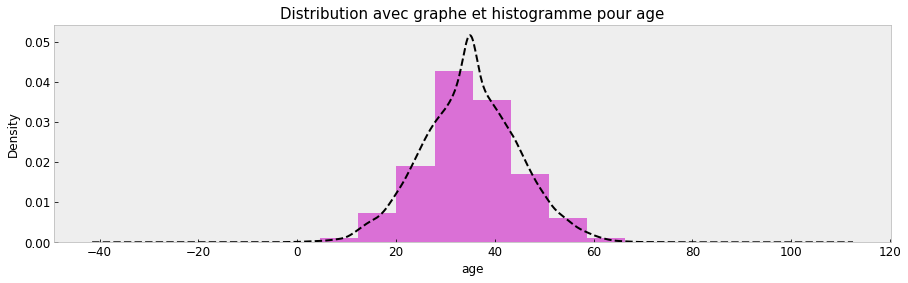

In [17]:
density_plot(df.age)

In [18]:
summary_stats(df.age)

,age
Stats,
skewness,0.011699
count,19909.000000
mean,35.004521
std,9.609169
min,-3.000000
25%,29.000000
50%,35.000000
75%,41.000000
max,74.000000


On remarque que la plupart des candidats sont dans la 30-aine, avec une distribution plutôt symétrique très proche d'une gaussienne centrée en 35. Cela est confirmé par une skewness très proche de 0.

On remarque des incohérences : plus de 170 candidats ont moins de 15 ans.

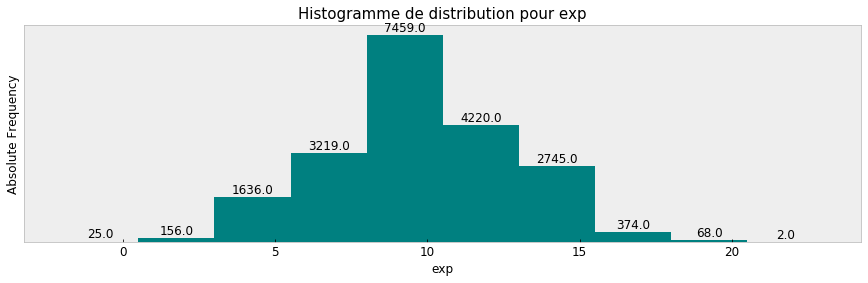

In [19]:
# Expérience
histogram(df.exp)

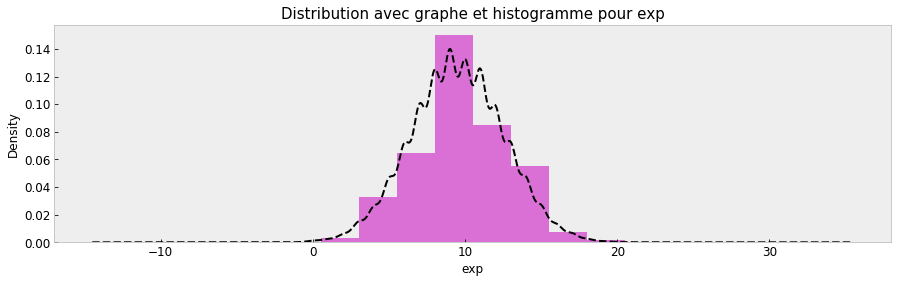

In [20]:
density_plot(df.exp)

In [21]:
summary_stats(df.exp)

,exp
Stats,
skewness,0.006383
count,19904.000000
mean,9.500352
std,3.012109
min,-2.000000
25%,7.000000
50%,9.000000
75%,12.000000
max,23.000000


La plupart des candidats ont une expérience proche de 10 ans, avec une distribution plutôt symétrique très proche d'une gaussienne centrée en 9. Cela est confirmé par une skewness très proche de 0.

Cela n'est pas étonnant. Il est normal d'avoir une dizaine d'années d'expérience professionnelle à 35 ans dans le monde de la recherche.

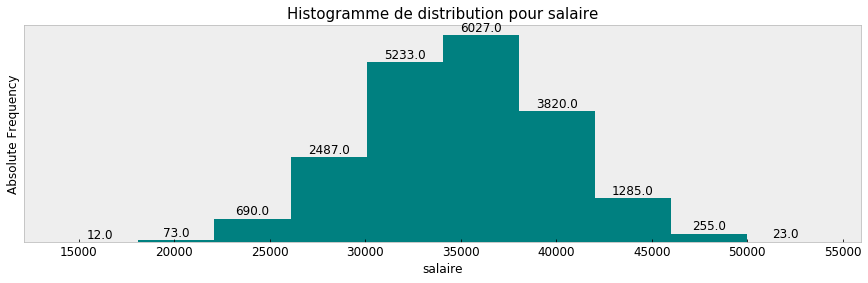

In [22]:
# Salaire demandé
histogram(df.salaire)

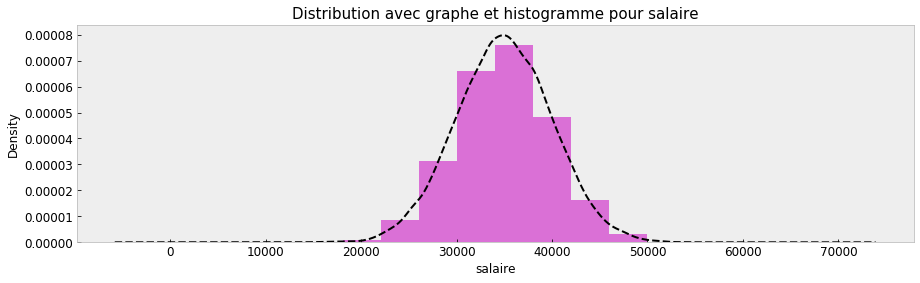

In [23]:
density_plot(df.salaire)

In [24]:
summary_stats(df.salaire)

,salaire
Stats,
skewness,-0.005519
count,19905.000000
mean,34974.343934
std,5003.099616
min,14128.000000
25%,31596.000000
50%,34979.000000
75%,38358.000000
max,53977.000000


La plupart des candidats demandent un salaire entre 30k et 40k, avec une distribution plutôt symétrique très proche d'une gaussienne centrée en 35k. Cela est confirmé par une skewness très proche de 0, cette fois négatif : Il semblerait que la moyenne soit centrée un peu plus à droite par rapport aux autres distributions.

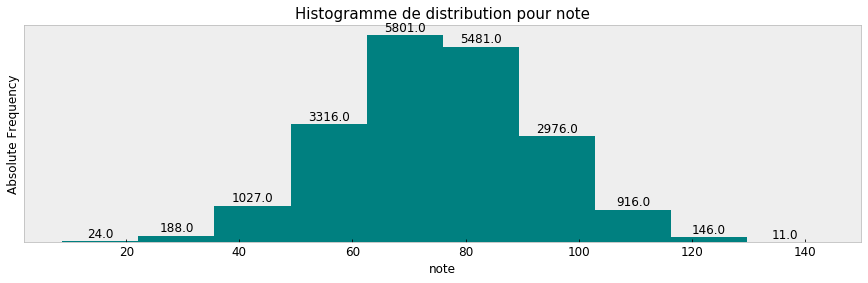

In [25]:
# Note
histogram(df.note)

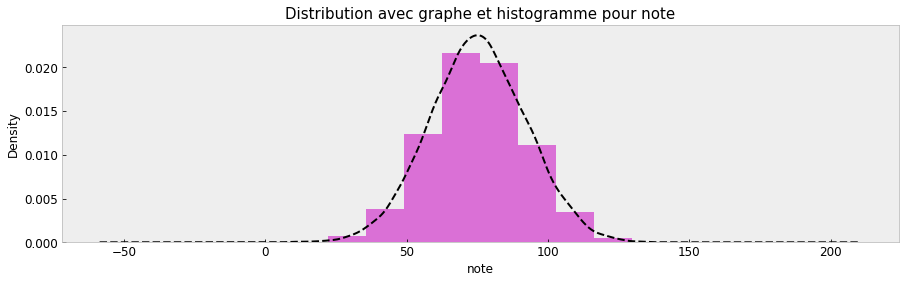

In [26]:
density_plot(df.note)

In [27]:
summary_stats(df.note)

,note
Stats,
skewness,-0.009946
count,19886.000000
mean,75.168762
std,17.095926
min,8.680000
25%,63.720000
50%,75.080000
75%,86.617500
max,143.220000


La plupart des candidats ont eu un score entre 60 et 90, avec une distribution plutôt symétrique très proche d'une gaussienne centrée en 75. Cela est confirmé par une skewness très proche de 0.

On remarque que plus de 1000 candidats ont une note supérieure à 100. Les variables contenant des incohérences suivent cependant une gaussienne symétrique, on peut donc se dire qu’il s’agit ici de la manière dont la donnée a été enregistrée par le logiciel et non des erreurs d’entrées par les candidats. On va donc garder les incohérences pour les données qui ont une distribution symétrique gaussienne.

## b. Dépendances statistiques significatives

### b.1. Nettoyage des données

Comme on l'a vu, certaines features demandent d'être retravaillées, que ce soient l'age ou la note qui possèdent des valeurs incohérentes, ou bien des NaN à gérer. Ensuite, nous pourrons plus aisément décrire les dépendances statistiques entre les variables.

Le choix ici sera entre retirer les lignes contenant des NaN, les remplacer par la moyenne de la colonne ou bien par la valeur la plus représentée. Le souci pour la dernière est l'apparition d'un biais.

In [28]:
# Gestion des valeurs nulles

# Fonction scatter
def scatter_plot(x, y, title, yaxis, size, c_scale):
    trace = go.Scatter(
    x = x,
    y = y,
    mode = 'markers',
    marker = dict(color = y, size = size, showscale = True, colorscale = c_scale))
    layout = go.Layout(hovermode= 'closest', title = title, yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], layout = layout)
    return iplot(fig)
    
# Afficher le nombre de valeurs manquantes par colonne
missing_columns = len(df) - df.loc[:, np.sum(df.isnull())>0].count()
x = missing_columns.index
y = missing_columns
title = 'Variables avec des valeurs manquantes'
scatter_plot(x, y, title, 'Valeurs manquantes', 30, 'Rainbow')

In [29]:
df_nona = df.dropna()
print("Nombre de lignes perdues :")
print(df.shape[0] - df_nona.shape[0])
print("Proucentage de lignes perdues :")
print((df.shape[0] - df_nona.shape[0])/df.shape[0])
print("Nombre de lignes avec embauche perdues :")
print(df[df["embauche"] == 1]["embauche"].count() - df_nona[df_nona["embauche"] == 1]["embauche"].count())
print("Proucentage de lignes avec embauche perdues :")
print((df[df["embauche"] == 1]["embauche"].count() - df_nona[df_nona["embauche"] == 1]["embauche"].count()) / df[df["embauche"] == 1]["embauche"].count())

Nombre de lignes perdues :
979
Proucentage de lignes perdues :
0.04895
Nombre de lignes avec embauche perdues :
113
Proucentage de lignes avec embauche perdues :
0.04930191972076789


Un dropna causerait une perte de 4.89% des données et 4.93% des données utiles pour l'entraînement de l'algorithme. Cela n'est pas négligeable.

Nous allons plutôt remplir les valeurs nulles.

In [30]:
# Valeurs catégoriques --------------------------

# Pour les cheveux, les sans réponse sont probablement les autres couleurs de cheveux
df.cheveux.fillna(value = 'autre', inplace = True)

# Pour le sexe, on va choisir M pour remplir les valeurs nulles
df.sexe.fillna(value = 'M', inplace = True)

# Pour le diplome, on va remplacer les valeurs nulles par la catégorie la plus représentée i.e. les masters
df.diplome.fillna(value = 'master', inplace = True)

# Pour la spécialité, on va remplacer les valeurs nulles par la catégorie la plus représentée i.e. géologie
df.specialite.fillna(value = 'geologie', inplace = True)

# Pour la dispo, on peut imaginer que les réponses nulles sont les réponses négatives
df.dispo.fillna(value = 'non', inplace = True)

In [31]:
# Valeurs numériques --------------------------

# Les distributions sont toutes gaussiennes ici, on peut donc remplacer les NaN par les moyennes

df.age.fillna(value = df.age.mean(), inplace = True)
df.exp.fillna(value = df.exp.mean(), inplace = True)
df.salaire.fillna(value = df.salaire.mean(), inplace = True)
df.note.fillna(value = df.note.mean(), inplace = True)

In [32]:
display(df.isnull().sum())

index          0
date          91
cheveux        0
age            0
exp            0
salaire        0
sexe           0
diplome        0
specialite     0
note           0
dispo          0
embauche       0
semestre      91
dtype: int64

### b.2. Analyse des dépendances

#### b.2.1 Entre la spécialité et le sexe

La spécialité et le sexe sont toutes deux des variables catégoriques : on va utiliser un test du chi 2. Commençons par implémenter une fonction qui affiche la fréquence d'une variable suivant une autre.

In [33]:
# Fonction qui va afficher la fréquence d'embauche en fonction d'une catégorie
def crosstab(cat, cat_target):
    '''cat = categorical variable, cat_target = our target categorical variable.'''
    global ax, ax1
    fig_size = (15,4)
    font_size = 12
    title_size = 15
    cat_grouped_by_cat_target = pd.crosstab(index = cat, columns = cat_target)
    cat_grouped_by_cat_target.rename({0:'Pas embauché', 1:'Embauché'}, axis = 'columns', inplace = True)  # Renaming the columns
    pct_cat_grouped_by_cat_target = round(pd.crosstab(index = cat, columns = cat_target, normalize = 'index')*100, 2)
    pct_cat_grouped_by_cat_target.rename({0:'Pas embauchés(%)', 1:'Embauchés(%)'}, axis = 'columns', inplace = True)
    
    # Affiche la fréquence absolue d'embauche par une catégorie
    ax =  cat_grouped_by_cat_target.plot.bar(title = 'Compte de %s' %cat_target.name + ' par %s' %cat.name, figsize = fig_size)
    ax.title.set_size(fontsize = title_size)
    abs_bar_labels()
    plt.xlabel(cat.name, fontsize = font_size)
    plt.show()
    
    # Affiche la fréquence relative d'embauche par une catégorie
    ax1 = pct_cat_grouped_by_cat_target.plot.bar(title = 'Compte de %s' %cat_target.name + ' par %s' %cat.name, figsize = fig_size)
    ax1.title.set_size(fontsize = title_size)
    pct_bar_labels()
    plt.xlabel(cat.name, fontsize = font_size)
    plt.show()
    
# Fonction calculant le Chi 2
def chi_square(cat, cat_target):
    cat_grouped_by_cat_target = pd.crosstab(index = cat, columns = cat_target)
    test_result = stats.chi2_contingency (cat_grouped_by_cat_target)
    print('Résultat du test du Chi 2 entre %s' %cat_target.name + ' et %s' %cat.name + ':')
    display(test_result)

# Fonction calculant la p-valeur ajustée de Bonferroni-adjusted pvalue
def bonferroni_adjusted(cat, cat_target):
    dummies = pd.get_dummies(cat)
    for columns in dummies:
        crosstab = pd.crosstab(dummies[columns], cat_target)
        print(stats.chi2_contingency(crosstab))
    print('\nColumns:', dummies.columns)

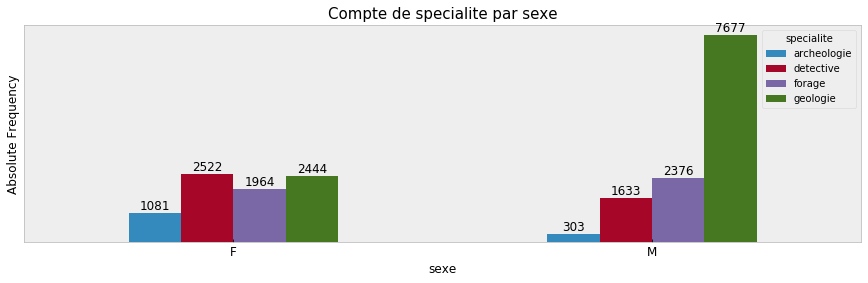

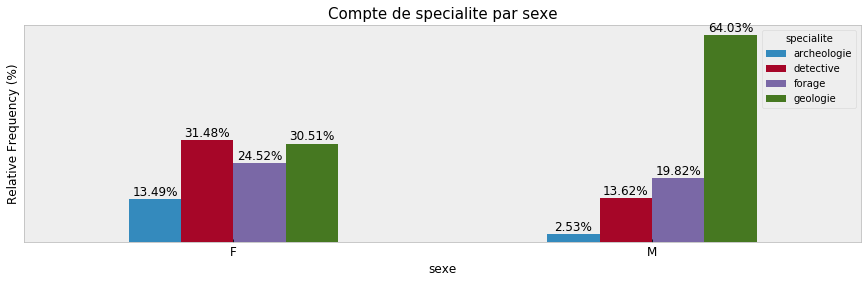

Résultat du test du Chi 2 entre specialite et sexe:


(2687.449690280542,
 0.0,
 3,
 array([[ 554.3612 , 1664.28525, 1738.387  , 4053.96655],
        [ 829.6388 , 2490.71475, 2601.613  , 6067.03345]]))

In [34]:
crosstab(df.sexe, df.specialite)
chi_square(df.sexe, df.specialite)

On remarque une p-valeur égale à 0.0. Cela implique qu'elle est si faible que le logiciel a choisi d'arrondir le résultat. La p-valeur étant inférieure à 0.001, les deux variables sont hautement correlées.

Comme le montre le graphe, si l'on est un homme, on a 64.03% de chances d'être un géologue contre 30.51% pour une femme. A contrario, on a moins de 20% de chances d'être un détective ou un foreur contre au moins 24% pour une femme.

#### b.2.2 Entre la couleur de cheveux et le salaire demandé

La couleur de cheveux est une variable catégorique alors que le salaire demandé est une variable numérique, la fonction écrite ne pourra pas fonctionner ici.

On va commencer par représenter la variable numérique pour chaque valeur de la variable catégorique avec un boxplot puis on procédera à une analyse en utilisant l'ANOVA.

In [35]:
# Fonction affichant les boxplots
def boxplot(cat,num):
    '''cat = categorical variable, and num = numerical variable.'''
    fig_size = (15,4)
    font_size = 12
    title_size = 15
    ax = sns.boxplot(x = cat, y = num)

    plt.title('Association entre %s' %cat.name + ' et %s' %num.name, fontsize = title_size)
    plt.xlabel('%s' %cat.name, fontsize = font_size)
    plt.ylabel('%s' %num.name, fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.show()

# Fonction pour représenter la moyenne pour chaque valeur de la variable catégorique
def nume_grouped_by_cat(cat, num):
    global ax
    font_size = 12
    title_size = 15
    grouped_by_cat = num.groupby(cat).mean().sort_values( ascending = False)
    grouped_by_cat = round(grouped_by_cat, 2)
    ax = grouped_by_cat.plot.bar(figsize = (18,5)) 
    abs_bar_labels()
    plt.title('Moyenne de %s ' %num.name + 'par %s' %cat.name, fontsize = title_size)
    plt.ylabel('Moyenne de %s ' %num.name, fontsize = font_size)
    plt.xlabel('%s' %cat.name, fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.show()

# Fonction pour représenter la distribution pour chaque valeur de la variable catégorique
def num_hist_by_cat(cat, num):
    font_size = 12
    title_size = 15
    plt.figure(figsize = (18,7))
    num[cat == 'blond'].hist(label = 'blond', grid = False)
    num[cat == 'chatain'].hist(label = 'chatain', grid = False)
    num[cat == 'brun'].hist(label = 'brun', grid = False)
    num[cat == 'roux'].hist(label = 'roux', grid = False)
    num[cat == 'autre'].hist(label = 'autre', grid = False)
    plt.yticks([])
    plt.xticks(fontsize = font_size)
    plt.xlabel('%s' %num.name, fontsize = font_size)
    plt.title('Distribution de %s ' %num.name + 'par %s' %cat.name, fontsize = title_size)
    plt.legend()
    plt.show()
   
# Fonction pour calculer l'ANOVA, qui renvoie la valeur de la F-satistique et la p-valeur
def anova(cat, num):
    from scipy import stats
    grp_num_by_cat_1 = num[cat == 'blond']
    grp_num_by_cat_1 = num[cat == 'chatain']
    grp_num_by_cat_1 = num[cat == 'brun']
    grp_num_by_cat_1 = num[cat == 'roux']
    grp_num_by_cat_0 = num[cat == 'autre']
    f_val, p_val = stats.f_oneway(grp_num_by_cat_1, grp_num_by_cat_0)
    print('Anova entre ' + num.name, ' et '+ cat.name, ' : ' , f_val, p_val)  

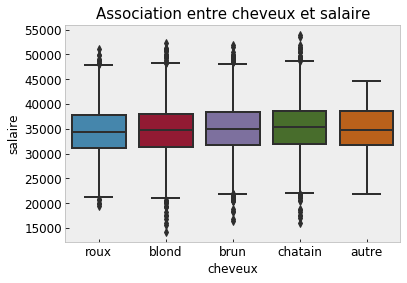

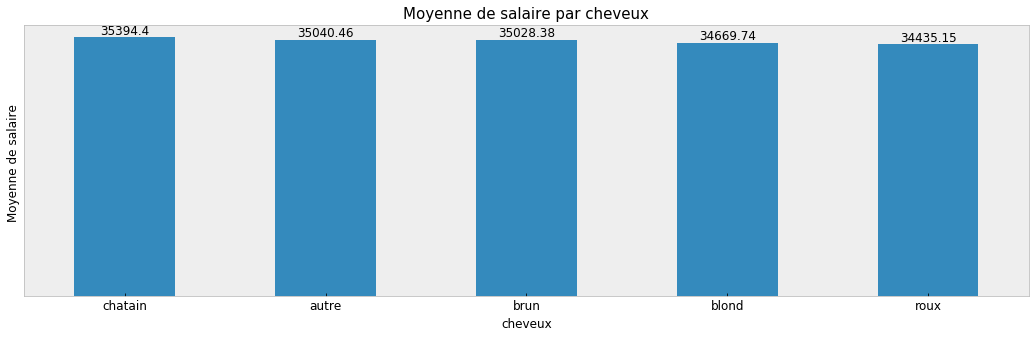

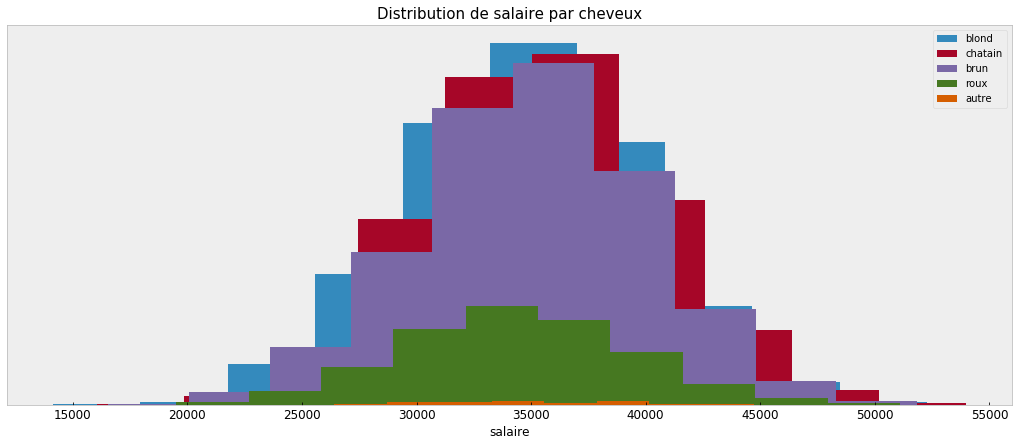

Anova entre salaire  et cheveux  :  1.4340397253546442 0.23124432479010631


In [36]:
boxplot(df.cheveux, df.salaire)
nume_grouped_by_cat(df.cheveux, df.salaire)
num_hist_by_cat(df.cheveux, df.salaire)
anova(df.cheveux, df.salaire)

La distribution de salaire entre les différentes couleurs de cheveux semble uniforme : la couleur de cheveux ferait un mauvais prédicteur de salaire.

La p-valeur est de 0.23, ce qui est largement supérieur à 0.05 : Les deux variables ne sont pas statistiquement dépendantes.

#### b.2.2 Entre le nombre d'années d'expérience et la note

Ici, les deux variables sont numériques : Il suffit de regarder la covariance et le coefficient de correlation de Pearson. 

In [37]:
covariance = np.cov(df.exp, df.note)
print(covariance)

[[  9.02925134  -0.62118961]
 [ -0.62118961 290.60467434]]


On remarque que les diagonales sont négatives : il semblerait que les deux variables soient donc négativement correlées. Si l'expérience augmente, la note diminue et vice-versa. 

Allons un peu plus loin avec le coefficient de Pearson :

In [38]:
from scipy.stats import pearsonr
corr, _ = pearsonr(df.exp, df.note)
print('Correlation de pearson: %.3f' % corr)

Correlation de pearson: -0.012


Bien que négative, la correlation entre les deux variables semble faible.

## 2. Machine Learning

## 1. Construction d'un modèle

### a. Processing de la donnée pour le modèle

A ce niveau, nous allons commencer par éliminer les colonnes qui n'ont aucun impact sur l'embauche : l'index, pour des raisons évidentes, et la date, qui est constante et semble plutôt montrer qu'OrFée embauche sur candidatures libres tout au long de l'année.

In [39]:
df.drop(columns = ['index', 'date', 'semestre'], inplace = True, axis = 1)

Nous allons aussi corriger le type des données : passer les objects en category

In [40]:
df.dtypes

cheveux        object
age           float64
exp           float64
salaire       float64
sexe           object
diplome        object
specialite     object
note          float64
dispo          object
embauche        int64
dtype: object

In [41]:
df.loc[:, ['cheveux', 'sexe', 'diplome', 'specialite', 'dispo']] = df.loc[:, ['cheveux', 'sexe', 'diplome', 'specialite', 'dispo']].astype('category')

In [42]:
df.dtypes

cheveux       category
age            float64
exp            float64
salaire        float64
sexe          category
diplome       category
specialite    category
note           float64
dispo         category
embauche         int64
dtype: object

On va maintenant transformer les données catégories en dummies à l'aide d'un hot encoding

In [43]:
df = pd.get_dummies(df)
df.head()

,age,exp,salaire,note,embauche,cheveux_autre,cheveux_blond,cheveux_brun,cheveux_chatain,cheveux_roux,...,diplome_bac,diplome_doctorat,diplome_licence,diplome_master,specialite_archeologie,specialite_detective,specialite_forage,specialite_geologie,dispo_non,dispo_oui
0,25.000000,9.0,26803.0,97.08,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,1,0
1,35.000000,13.0,38166.0,63.86,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
2,29.000000,13.0,35207.0,78.50,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,1,0
3,35.004521,12.0,32442.0,45.09,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,1,0
4,35.000000,6.0,28533.0,81.91,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0


### b. Choix et entraînement du modèle

Nous sommes ici dans un contexte de supervised learning pour faire de la classification binaire : notre candidat sera-t-il embauché ou non ?

In [44]:
# On initialise un seed pour reproduire les résultats
seed = 50

# On va arranger le dataframe pour la suite
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('embauche')))
df = df.reindex(columns= cols)

# On divise notre set en un training set et un test set
X = df.iloc[:, 1:22].values
y = df.iloc[:, 0].values

# On split le set en training et test sets
# Nous avons 20k données, un split 20/80 semble être un bon compromis
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = seed)

# On fait du feature scaling afin de donner le même poids à chaque variable
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print('Input Matrix:  ', X_train.shape)
print('Output Vector: ', y_train.shape)
print('Test Data:     ', X_test.shape)

Input Matrix:   (16000, 21)
Output Vector:  (16000,)
Test Data:      (4000, 21)


In [45]:
# On va maintenant tester plusieurs modèles
# Nous sommes dans un cas où la base de données est relativement petite (20k lignes, et 15k de training) 
# avec seulement 11% d'embauches, il faudra donc un modèle qui n'a pas besoin de beaucoup de données pour
# bien généraliser. On peut s'attendre à ce que les modèles arborescents et boostés donnent les meilleurs scores.

# Régression Logistique
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

# Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = seed)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = seed, n_estimators = 100)

# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state = seed)

In [46]:
# On va regarder la performance d'entrainement de chaque modèle, cette fonction va renvoyer l'accuracy de
# chaque modèle par défaut i.e. nb de prédictions correctes sur nb de prédictions total
def train_accuracy(model):
    model.fit(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)
    train_accuracy = np.round(train_accuracy*100, 2)
    return train_accuracy

In [47]:
# On calcule le score pour chaque modèle
train_accuracy = pd.DataFrame({'Train_accuracy(%)':[train_accuracy(lr), train_accuracy(rf), train_accuracy(knn), train_accuracy(dt), train_accuracy(gbc)]})
train_accuracy.index = ['LR', 'RF', 'KNN', 'DT', 'GBC']
sorted_train_accuracy = train_accuracy.sort_values(by = 'Train_accuracy(%)', ascending = False)
suppress_warnings()

C:\Users\Jeremy\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [48]:
train_accuracy

,Train_accuracy(%)
LR,88.48
RF,100.00
KNN,93.01
DT,100.00
GBC,91.14


On voit que, comme attendu, les meilleures accuracies sont données par les modèles arborescents. Cependant, un score de 100 est choquant : il est probable qu'il y ait de l'overfitting.

De manière générale, on ne peut pas encore dire à ce stade si le modèle est capable de généraliser aux données nouvelles à partir de l'accuracy, étant donné que le modèle est testé sur le training set lui-même i.e. des données qu'il "connait" déjà.

Ce que l'on peut faire pour obtenir une accuracy plus représentative, c'est une cross-validation.

In [49]:
# Fonction qui renvoie le score moyen pour une 10-fold cross-validation
def x_val_score(model):
    from sklearn.model_selection import cross_val_score
    x_val_score = cross_val_score(model, X_train, y_train, cv = 10, scoring = 'accuracy').mean()
    x_val_score = np.round(x_val_score*100, 2)
    return x_val_score

x_val_score = pd.DataFrame({'x_val_score(%)':[x_val_score(lr), x_val_score(rf), x_val_score(knn), x_val_score(dt), x_val_score(gbc)]})
x_val_score.index = ['LR', 'RF', 'KNN', 'DT', 'GBC']
sorted_x_val_score = x_val_score.sort_values(by = 'x_val_score(%)', ascending = False)
x_val_score
suppress_warnings()

On voit que les modèles arborescents ne font plus d'overfitting massif. Les modèles qui ont un accuracy de cross-validation le plus haut sont RandomForest, KNN et Logistic Regression.

On va maintenant utiliser le grid search pour tuner les hyperparamètres, dans l'espoir de peut-être augmenter les accuracies de chaque clasifieur, et augmenter la performance globale du modèle.

In [50]:
from sklearn.model_selection import GridSearchCV

def grid_search(classifier, parameters):
    grid_search = GridSearchCV(estimator = classifier,
                               param_grid = parameters,
                               scoring = 'accuracy',
                               cv = 10,
                               n_jobs = -1)
    grid_search = grid_search.fit(X_train, y_train)
    best_accuracy = np.round(grid_search.best_score_*100,2)
    best_parameters = grid_search.best_params_
    return best_parameters, best_accuracy

In [51]:
# On va définir les hyperparamètres usuels à tuner de chaque algorithme pour le gridsearch

# Régression logistique
lr_params = {'penalty':['l1', 'l2'],
             'C': np.logspace(0, 4, 10)}

# Arbre de décision
dt_params = {'max_features': ['auto', 'sqrt', 'log2'],
             'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 
             'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
             'random_state':[seed]}

# Random Forest
rf_params = {'criterion':['gini','entropy'],
             'n_estimators':[10, 15, 20, 25, 30],
             'min_samples_leaf':[1, 2, 3],
             'min_samples_split':[3, 4, 5, 6, 7], 
             'max_features':['sqrt', 'auto', 'log2'],
             'random_state':[44]}

# KNN
knn_params = {'n_neighbors':[3, 4, 5, 6, 7, 8],
              'leaf_size':[1, 2, 3, 5],
              'weights':['uniform', 'distance'],
              'algorithm':['auto', 'ball_tree','kd_tree','brute']}

# GBC
gbc_params = {'learning_rate': [0.01, 0.02, 0.05, 0.01],
              'max_depth': [4, 6, 8],
              'max_features': [1.0, 0.3, 0.1], 
              'min_samples_split': [ 2, 3, 4],
              'random_state':[seed]}

In [52]:
# ATTENTION cette étape peut prendre jusqu'à 20 minutes

# LR
lr_best_params, lr_best_score = grid_search(lr, lr_params)

# DT
dt_best_params, dt_best_score = grid_search(dt, dt_params)

# RF
rf_best_params, rf_best_score = grid_search(rf, rf_params)

# KNN
knn_best_params, knn_best_score = grid_search(knn, knn_params)

# GBC
gbc_best_params, gbc_best_score = grid_search(gbc, gbc_params)

suppress_warnings()

In [53]:
tunned_scores = pd.DataFrame({'Tunned_accuracy(%)': [lr_best_score, dt_best_score, rf_best_score, knn_best_score, gbc_best_score]})
tunned_scores.index = ['LR', 'DT', 'RF', 'KNN', 'GBC']
sorted_tunned_scores = tunned_scores.sort_values(by = 'Tunned_accuracy(%)', ascending = False)
sorted_tunned_scores

,Tunned_accuracy(%)
GBC,92.28
RF,92.24
KNN,91.41
DT,90.44
LR,88.48


On prendra pour la suite les deux modèles qui ont l'accuracy la plus haute après le tuning des hyperparamètres, c'est à dire le Gradient Boosting Classifier et le Random Forest.

On va maintenant réentrainer les modèles avec les paramètres optimaux. On devrait obtenir des scores similaires au tunned accuracy avec une cross-validation.

In [54]:
rf  = RandomForestClassifier(**rf_best_params)
gbc = GradientBoostingClassifier(**gbc_best_params)

models = {'GBC':gbc, 'RF':rf}
score = []
for x, (keys, items) in enumerate(models.items()):
    from sklearn.model_selection import cross_val_score
    items.fit(X_train, y_train)
    scores = cross_val_score(items, X_train, y_train, cv = 10, scoring = 'accuracy')*100
    score.append(scores.mean())
    print('Accuracy du '+ str(keys) + ' : ' + str(scores.mean()))

Accuracy du GBC : 92.28129444337674
Accuracy du RF : 92.2438061596899


Observation des prédictions à l'aide de la matrice de confusion :

In [55]:
def x_val_predict(model):
    from sklearn.model_selection import cross_val_predict
    predicted = cross_val_predict(model, X_train, y_train, cv = 10)
    return predicted

def confusion_matrix(model):
    predicted = x_val_predict(model)
    confusion_matrix = pd.crosstab(y_train, predicted, rownames = ['Vraie valeur'], colnames = ['Prédiction'], margins = True)
    return display(confusion_matrix)

In [56]:
print('Gradient Boosting Classifier :')
confusion_matrix(gbc)

Gradient Boosting Classifier :


Prédiction,0,1,All
Vraie valeur,,,
0,14017,139,14156
1,1096,748,1844
All,15113,887,16000


In [57]:
print('Random Forest :')
confusion_matrix(rf)

Random Forest :


Prédiction,0,1,All
Vraie valeur,,,
0,13954,202,14156
1,1039,805,1844
All,14993,1007,16000


On remarque que les deux matrices sont globalement similaires en ordres de grandeur. 

Suivant la sensibilité de notre problème, il est important de comparer les scores (Precision, Recall et Specificity) afin de savoir quel modèle performe le mieux pour ce que l'on veut. Par exemple, s'il est très important de bien classer les vrais positifs et que l’on est sensible aux faux positifs car l'on tient à embaucher des candidats qualifiés, il faudra voir quel modèle a le meilleure score Precision.

In [58]:
def precision_score(model):
    from sklearn.metrics import precision_score
    predicted = x_val_predict(model)
    f1_score = precision_score(y_train, predicted)
    return np.round(f1_score*100, 2)

def recall_score(model):
    from sklearn.metrics import recall_score
    predicted = x_val_predict(model)
    f1_score = recall_score(y_train, predicted)
    return np.round(f1_score*100, 2)

def f1_score(model):
    from sklearn.metrics import f1_score
    predicted = x_val_predict(model)
    f1_score = f1_score(y_train, predicted)
    return np.round(f1_score*100, 2)

print('Precision Score du GBC :', precision_score(gbc))
print('Precision Score du RF:', precision_score(rf))

print('Recall Score du GBC :', recall_score(gbc))
print('Recall Score du RF:', recall_score(rf))

print('F1 Score du GBC :', f1_score(gbc))
print('F1 Score du RF:', f1_score(rf))

Precision Score du GBC : 84.33
Precision Score du RF: 79.94
Recall Score du GBC : 40.56
Recall Score du RF: 43.66
F1 Score du GBC : 54.78
F1 Score du RF: 56.47


On voit que le GBC dépasse le RF sur l'accuracy et le precision score. Le RF est quant à lui meilleur sur le recall et le F1 score.

Sachant que nous voulons ici un modèle qui privilégie les bonnes embauches, nous allons choisir celui avec le meilleur score de précision, c'est à dire le GBC.

### c. Test du modèle

Maintenant que nous avons paramétré, entraîné et choisi notre modèle, procédons au test du modèle avec le test set.

In [59]:
y_pred = gbc.predict(X_test)

In [60]:
pd.crosstab(y_test, y_pred, rownames = ['Vraie valeur'], colnames = ['Prédiction'], margins = True)

Prédiction,0,1,All
Vraie valeur,,,
0,3529,23,3552
1,268,180,448
All,3797,203,4000


In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Accuracy Score du modèle : ' + str(np.round(accuracy_score(y_test, y_pred)*100, 2)))
print('Precision Score du modèle : ' + str(np.round(precision_score(y_test, y_pred)*100, 2)))

Accuracy Score du modèle : 92.72
Precision Score du modèle : 88.67


Notre modèle a une accuracy de 92.72, ce qui est un score respectable pour un modèle de classification. Son precision score est de 88.67, ce qui montre que c'est un modèle performant quand il s'agit de classer correctement les vrais positifs.

### d. Features importantes pour le modèle

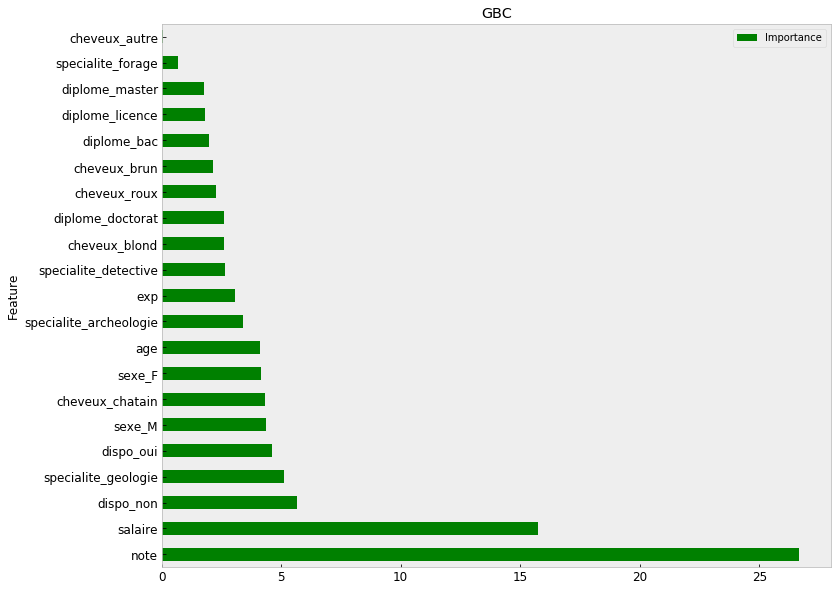

In [62]:
df_temp = df.drop(columns = ['embauche'], axis = 1)

importance = pd.DataFrame({'Feature': df_temp.columns.values, 'Importance': np.round(gbc.feature_importances_*100,3)})
importance = importance.sort_values(by = 'Importance', ascending = False).set_index('Feature')

fig, axes = plt.subplots(1,1, figsize = (12,10))
importance.plot.barh(ax = axes, title = 'GBC', fontsize = 12, color = 'green')

On voit ici que les features les plus importantes sont la note qui compte pour plus de 25% dans la prise de décision, le salaire demandé qui compte pour plus de 15%, et la disponibilité qui compte pour plus de 5% si celle-ci est négative.